In [1]:
# ---------------------------------------------------------
# CELL 1: SYSTEM PATH CONFIGURATION AND CONNECTION
# ---------------------------------------------------------
import sys
import os
from pathlib import Path

# Automatic Root Discovery
# We assume this notebook is nested in research/00_data_assurance/
# So we go: Current Dir -> Parent (00_data_assurance) -> Parent (research) -> Parent (Bluegrey Root)
NOTEBOOK_DIR = Path(os.getcwd()).resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent

# Verify we found the right root (look for 'src' folder)
if not (PROJECT_ROOT / "src").exists():
    # Fallback: Try going up just one level if you decided to put it directly in 'research'
    PROJECT_ROOT = NOTEBOOK_DIR.parent
    if not (PROJECT_ROOT / "src").exists():
        raise FileNotFoundError(f"CRITICAL: Could not find project root from {NOTEBOOK_DIR}")

# Add to System Path so we can import 'src'
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print(f"✅ Project Root identified: {PROJECT_ROOT}")

# --- IMPORTS ---
import pandas as pd
import matplotlib.pyplot as plt
import src.config as config  # Now this works perfectly
from arcticdb import Arctic

# --- CONFIGURATION ---
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.5f}'.format) # FX needs 5 decimals
plt.style.use('bmh') # Better chart visualization style

# Connect to the Vault
store = Arctic(config.ARCTIC_PATH)
lib_name = config.LIBS["fx_min"]
lib = store[lib_name]

print(f"✅ Connected to {config.ARCTIC_PATH}")
print(f"📚 Library: {lib_name}")
print(f"📈 Total Symbols: {len(lib.list_symbols())}")

print("✅ System Ready.")

✅ Project Root identified: C:\Users\7325\Documents\Bluegrey
✅ Connected to lmdb://C:\Users\7325\Documents\Bluegrey\data/arctic_db?map_size=500GB
📚 Library: fx.min
📈 Total Symbols: 167
✅ System Ready.


**The "Liquid 10" Snapshot**<br> Let's see what we actually have

In [2]:
# List first 10 symbols to verify our filter worked
symbols = lib.list_symbols()
print("First 10 Instruments:", symbols[:10])

# Check the data range for EURUSD (The King of Pairs)
test_pair = "C:EURUSD"
if test_pair in symbols:
    info = lib.read_metadata(test_pair) # Fast read of metadata if available
    # Arctic doesn't always store metadata by default unless we set it, 
    # so let's just read the head/tail of the dataframe.
    
    df = lib.read(test_pair).data
    print(f"\n--- {test_pair} Summary ---")
    print(f"Start: {df.index[0]}")
    print(f"End:   {df.index[-1]}")
    print(f"Rows:  {len(df):,}")
    print(f"Columns: {df.columns.tolist()}")
else:
    print(f"⚠️ {test_pair} not found! Check your download list.")

First 10 Instruments: ['C:AUDEUR', 'C:JPYCAD', 'C:CHFJPY', 'C:SEKZAR', 'C:EURZAR', 'C:SGDGBP', 'C:SGDSEK', 'C:AUDHKD', 'C:NZDMXN', 'C:CADSGD']

--- C:EURUSD Summary ---
Start: 2020-01-02 06:59:00
End:   2026-01-02 01:56:00
Rows:  2,200,747
Columns: ['open', 'high', 'low', 'close', 'volume', 'vwap']



__Visual Sanity Check__:<br>
We look for "Gaps" (vertical white spaces where data is missing) and "Spikes" (bad ticks).


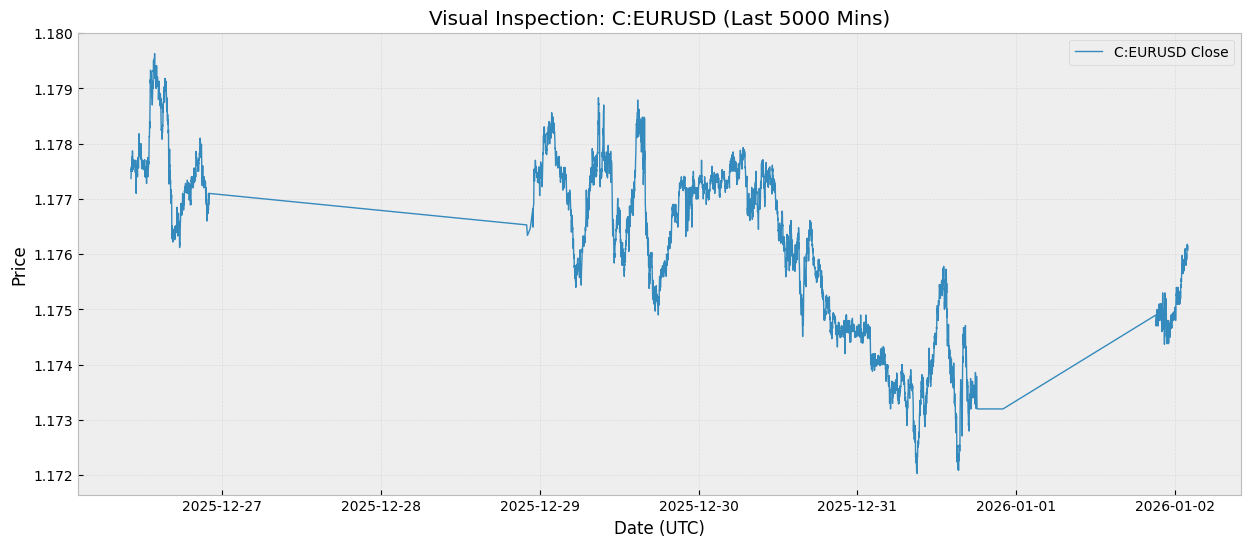

In [3]:
# Plotting the last 5,000 bars (approx 3.5 days of trading)
# We use Matplotlib here for simplicity. 
plt.figure(figsize=(15, 6))
plt.plot(df['close'].tail(5000), label=f'{test_pair} Close', linewidth=1)
plt.title(f"Visual Inspection: {test_pair} (Last 5000 Mins)")
plt.xlabel("Date (UTC)")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Gap Detection (The Pro Move)**:<br>
Markets sleep on weekends, but they shouldn't sleep on a Tuesday at 2 PM. This script checks for abnormal gaps.

In [4]:
# Calculate time difference between rows
df['delta'] = df.index.to_series().diff()

# Standard gap is 1 minute. We look for gaps > 5 minutes.
gaps = df[df['delta'] > pd.Timedelta(minutes=5)]

print(f"Found {len(gaps)} gaps larger than 5 minutes.")

# Show the top 5 largest gaps (likely weekends)
print("\nTop 5 Largest Gaps (Expect Weekends ~2 days):")
print(gaps['delta'].nlargest(5))

Found 1714 gaps larger than 5 minutes.

Top 5 Largest Gaps (Expect Weekends ~2 days):
timestamp
2020-11-15 17:00:00   22 days 20:01:00
2021-01-03 22:00:00    3 days 07:59:00
2020-12-27 17:44:00    3 days 03:41:00
2025-04-20 21:00:00    3 days 00:00:00
2024-11-25 14:08:00    2 days 16:09:00
Name: delta, dtype: timedelta64[ns]


In [5]:
# ---------------------------------------------------------
# ROBUST GAP DETECTION
# ---------------------------------------------------------

# 1. PREP: Sort and Deduplicate (Crucial for patched data)
df.sort_index(inplace=True)
df = df[~df.index.duplicated(keep='first')]

# 2. CALC: Time difference between rows
# We use 'shift' to compare Row N vs Row N-1 easily
actual_gaps = df.index.to_series().diff()

# 3. FILTER: Define "Gap" (e.g., > 5 minutes)
GAP_THRESHOLD = pd.Timedelta(minutes=5)
gap_mask = actual_gaps > GAP_THRESHOLD

# Create a clean summary DataFrame of the gaps
gap_df = pd.DataFrame({
    'gap_start': df.index[gap_mask].to_series().shift(1).dt.strftime('%Y-%m-%d %H:%M'), # The last bar BEFORE the gap
    'gap_end':   df.index[gap_mask].strftime('%Y-%m-%d %H:%M'),                         # The first bar AFTER the gap
    'duration':  actual_gaps[gap_mask]
})

# 4. REPORT
print(f"✅ Analysis Complete on {len(df):,} bars.")
print(f"🔎 Found {len(gap_df)} gaps larger than {GAP_THRESHOLD}.\n")

if not gap_df.empty:
    print("--- TOP 10 LARGEST GAPS ---")
    # Show the biggest ones (usually weekends or holidays)
    print(gap_df.sort_values('duration', ascending=False).head(10))
    
    # 5. VERIFY NO "GHOSTS"
    # Check if any gap > 4 days (Market should rarely close for > 4 days even on Easter)
    suspicious = gap_df[gap_df['duration'] > pd.Timedelta(days=4)]
    if not suspicious.empty:
        print("\n⚠️ WARNING: SUSPICIOUS GAPS DETECTED (> 4 Days) ⚠️")
        print(suspicious)
    else:
        print("\n✨ Data Integrity Verified: No gaps larger than 4 days found.")
else:
    print("✨ Perfect Continuity. No gaps found.")

✅ Analysis Complete on 2,200,747 bars.
🔎 Found 1714 gaps larger than 0 days 00:05:00.

--- TOP 10 LARGEST GAPS ---
                            gap_start           gap_end         duration
timestamp                                                               
2020-11-15 17:00:00  2020-10-18 21:00  2020-11-15 17:00 22 days 20:01:00
2021-01-03 22:00:00  2020-12-28 17:28  2021-01-03 22:00  3 days 07:59:00
2020-12-27 17:44:00  2020-12-20 17:00  2020-12-27 17:44  3 days 03:41:00
2025-04-20 21:00:00  2025-04-17 21:00  2025-04-20 21:00  3 days 00:00:00
2024-11-25 14:08:00  2024-11-17 22:00  2024-11-25 14:08  2 days 16:09:00
2021-05-24 12:56:00  2021-05-18 04:52  2021-05-24 12:56  2 days 15:54:00
2021-11-22 05:19:00  2021-11-14 21:06  2021-11-22 05:19  2 days 07:19:00
2022-01-17 01:51:00  2022-01-09 22:27  2022-01-17 01:51  2 days 03:50:00
2021-12-06 13:56:00  2021-12-04 10:26  2021-12-06 13:56  2 days 03:30:00
2021-12-13 11:15:00  2021-12-11 08:21  2021-12-13 11:15  2 days 02:54:00

⚠️ WARNI

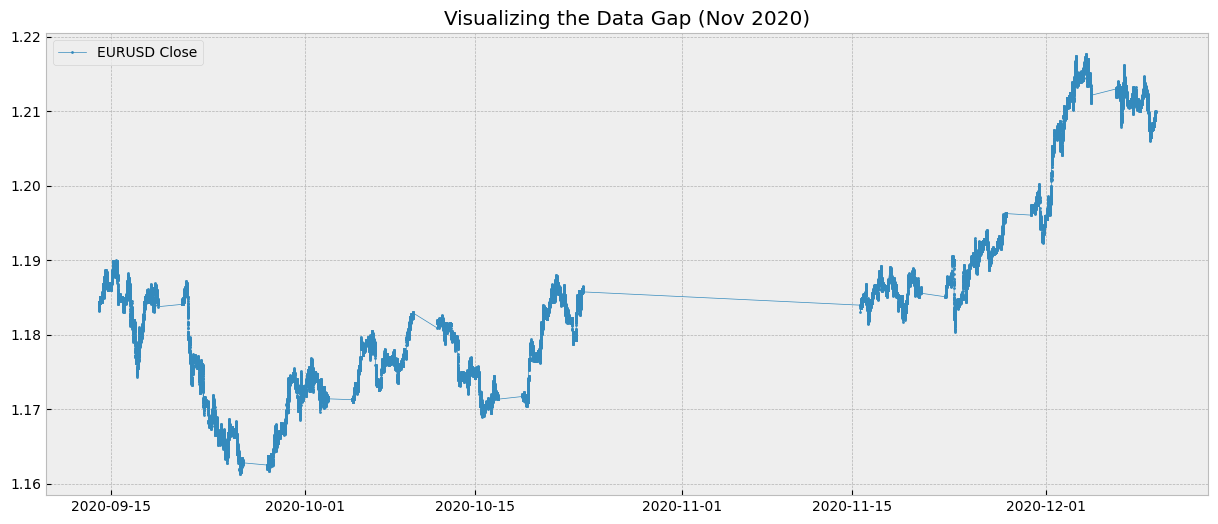

First timestamp after gap: 2020-11-20 00:01:00


In [6]:
# Zoom in on the "Event Horizon"
gap_start = pd.Timestamp("2020-09-14")
gap_end = pd.Timestamp("2020-12-10")

# Slice the data
subset = df[gap_start:gap_end]

# Plot with markers to see exactly where it stops and starts
plt.figure(figsize=(15, 6))
plt.plot(subset['close'], '.-', markersize=2, linewidth=0.5, label='EURUSD Close')
plt.title("Visualizing the Data Gap (Nov 2020)")
#plt.axvspan(pd.Timestamp("2020-11-16"), pd.Timestamp("2020-12-07"), color='red', alpha=0.1, label='Missing Data')
plt.legend()
plt.show()

print("First timestamp after gap:", subset[subset.index > pd.Timestamp("2020-11-20")].index[0])

In [13]:
# 1. Force Sort to ensure 'diff()' works correctly
df.sort_index(inplace=True)

# 2. Define the "Scene of the Crime"
target_start = "2020-10-17 12:00"
target_end   = "2020-11-16 12:00"

print(f"🔎 INSPECTING DATA: {target_start} to {target_end}")
subset = df[target_start:target_end]

if subset.empty:
    print("❌ NO DATA found in this specific window.")
else:
    print(f"✅ Found {len(subset)} rows.")
    print("\n--- FIRST 5 ROWS ---")
    print(subset[['close', 'volume']].head())
    print("\n--- LAST 5 ROWS ---")
    print(subset[['close', 'volume']].tail())

# 3. Check the specific jump identified earlier
print("\n🔎 CHECKING THE JUMP AT 2020-10-17")
# Find the row exactly at or before the alleged gap start
gap_row = df.asof(pd.Timestamp("2020-10-17 17:00:00")) 
# (Note: asof finds the nearest valid index)

if not gap_row.empty:
    # Get the integer location of this timestamp
    try:
        loc = df.index.get_loc(pd.Timestamp("2020-10-17 17:00:00"))
        # Print the row itself and the NEXT row
        print("\n--- THE GAP LOCATION ---")
        print(df.iloc[loc:loc+2][['close', 'volume']])
    except KeyError:
        print("⚠️ Exact timestamp 2020-10-17 17:00:00 not found in index.")
        # Fallback: Search nearby
        nearby = df["2020-11-15":"2020-11-16"]
        if nearby.empty:
             print("❌ CONFIRMED: No data between Oct 17 and Nov 17.")
        else:
             print(f"✅ DATA EXISTS! Found {len(nearby)} rows between Nov 15 and Dec 5.")
             print(nearby[['close']].head())

🔎 INSPECTING DATA: 2020-10-17 12:00 to 2020-11-16 12:00
✅ Found 8297 rows.

--- FIRST 5 ROWS ---
                      close  volume
timestamp                          
2020-10-18 21:00:00 1.17169       1
2020-10-18 21:01:00 1.17198       1
2020-10-18 21:02:00 1.17198       5
2020-10-18 21:04:00 1.17181       5
2020-10-18 21:05:00 1.17181      15

--- LAST 5 ROWS ---
                      close  volume
timestamp                          
2020-11-16 11:56:00 1.18431      57
2020-11-16 11:57:00 1.18439     186
2020-11-16 11:58:00 1.18437     189
2020-11-16 11:59:00 1.18437      97
2020-11-16 12:00:00 1.18418     175

🔎 CHECKING THE JUMP AT 2020-10-17
⚠️ Exact timestamp 2020-10-17 17:00:00 not found in index.
✅ DATA EXISTS! Found 1849 rows between Nov 15 and Dec 5.
                      close
timestamp                  
2020-11-15 17:00:00 1.18395
2020-11-15 17:01:00 1.18400
2020-11-15 17:02:00 1.18380
2020-11-15 17:03:00 1.18383
2020-11-15 17:04:00 1.18380
